In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from importlib import reload

sys.path.append(r'C:\Users\espov\Documents\Python\xrt')
from xrt.backends.raycing.sources import GeometricSource

plt.style.use('dark_background')
#matplotlib.rcParams.keys()
# matplotlib.rcParams['figure.facecolor'] = 'grey'
matplotlib.rcParams['figure.figsize'] = (11, 7)
matplotlib.rc('font', size=14)
length = 8
width = 1.5
matplotlib.rcParams['xtick.major.size'] = length
matplotlib.rcParams['ytick.major.size'] = length
matplotlib.rcParams['xtick.major.width'] = width
matplotlib.rcParams['ytick.major.width'] = width

In [3]:
def propagation(d):
    return np.array([[1,d],[0,1]])

def focus(f):
    return np.array([[1,0],[-1/f,1]])


def LCLS_source_properties(E0, instrument='origin'):
    """
    LCLS source size and divergence (from Hasan's spreadsheet)
    input:
        en: photon energy [eV]
    output:
        FWHM: source size [mm]
        div: source divergence [urad]
    """        
    if E0>=2000 and E0<8000:
        FWHM = 45*(5000/E0) #um
        div = 3.4*(5000/E0) #um
    if E0>=8000 and E0<=13000:
        FWHM = 37*(8000/E0)**0.25 #urad
        div = 2*(8000/E0)**0.25 #urad
    # div = 0
    
    d = {'origin':0, 'TXI':140, 'XPP':150, 'XCS':400, 'MFX':415, 'CXI':425, 'MEC':440} #[m]
    # Sample position for each instrument
    d = d[instrument]
    FWHM = FWHM + div*d #um
    dx = FWHM/1000/2.634 # sigma [mm]
    dz = FWHM/1000/2.634 # sigma [mm]
    dxprime = div /1e6 # [rad]
    dzprime = div /1e6 # [rad]
    return dx, dz, dxprime, dzprime

In [4]:
E = 4400
instrument = 'TXI'
dx, dz, dxprime, dzprime = LCLS_source_properties(E, instrument=instrument)
# dzprime = 3*dzprime

s1 = np.array([dz,dzprime])
print(s1)
p1 = propagation(0)
m1 = focus(300)
p2 = propagation(600)
m2 = focus(300)
setup = np.dot(p1,m1)
sout = np.dot(setup,s1)
print(sout)

[2.24770484e-01 3.86363636e-06]
[ 0.22477048 -0.00074537]


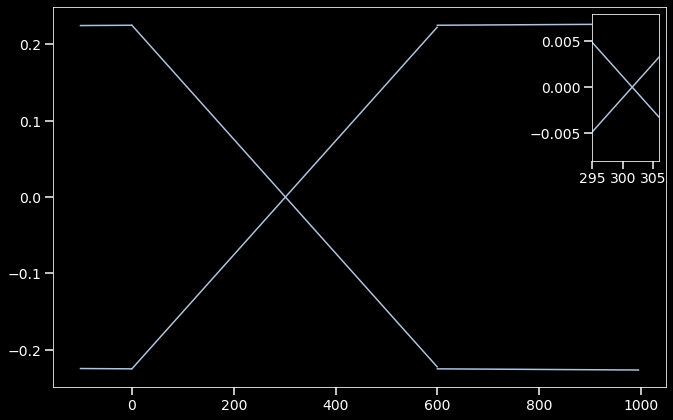

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
color = 'lightsteelblue'

d0 = np.arange(-101,0,5)
d1 = np.arange(0,600,0.5)
d2 = np.arange(600,1000,5)
s1s = [np.array([dz,dzprime]), np.array([-dz,-dzprime])]
ax = plt.subplot(111)
axins = zoomed_inset_axes(ax, 12, loc=1) # zoom-factor: 2.5, location: upper-left
for s in s1s:
    traj = np.asarray([np.dot(propagation(di),s) for di in d0])
    ax.plot(d0,traj[:,0],c=color)
    
    setup = np.dot(p1,m1)
    sout = np.dot(setup,s)
    traj = np.asarray([np.dot(propagation(di),sout) for di in d1])
    ax.plot(d1,traj[:,0],c=color)
    axins.plot(d1,traj[:,0],c=color)
    axins.set_xlim(295, 306) # apply the x-limits
    axins.set_ylim(-0.008, 0.008) # apply the y-limits
    
    setup = np.dot(np.dot(np.dot(p1,m1),p2),m2)
    sout = np.dot(setup,s)
    traj = np.asarray([np.dot(propagation(di),sout) for di in d2])
    ax.plot(d2,traj[:,0],c=color)
    
axins.yaxis.set_visible('False')
plt.show()

In [6]:
p2 = propagation(600)
m2 = focus(300)
setup = np.dot(np.dot(np.dot(p1,m1),p2),m2)
sout = np.dot(setup,s1)
print(s1)
print(sout)
print(s1+sout)

[2.24770484e-01 3.86363636e-06]
[-2.22452302e-01 -3.86363636e-06]
[0.00231818 0.        ]


# Analytical calculation

In [7]:
import sympy as sp
D,d,f, x, theta = sp.symbols('D d f x theta') # distance, mirror distance, focal
d1 = sp.Matrix([[1,D],[0,1]])
m1 = sp.Matrix([[1,0],[-1/f,1]])
d2 = sp.Matrix([[1,d],[0,1]])
m2 = sp.Matrix([[1,0],[-1/f,1]])
setup = m2*d2*m1*d1
ray = sp.Matrix([[x],[theta]])
rayout = setup*ray

In [8]:
rayout

Matrix([
[                            theta*(D*(-d/f + 1) + d) + x*(-d/f + 1)],
[theta*(D*(-(-d/f + 1)/f - 1/f) - d/f + 1) + x*(-(-d/f + 1)/f - 1/f)]])

In [9]:
rayout_2f = rayout.subs(d,2*f)
rayout_2f

Matrix([
[theta*(-D + 2*f) - x],
[              -theta]])

In [10]:
rayout.simplify()

In [11]:
rayout

Matrix([
[               -(theta*(D*(d - f) - d*f) + x*(d - f))/f],
[(-theta*(D*(-d + 2*f) + d*f - f**2) + x*(d - 2*f))/f**2]])

In [12]:
rayout_2f.simplify()
rayout_2f

Matrix([
[-theta*(D - 2*f) - x],
[              -theta]])